# Experimenting different architectures from scractch and using pre-trained Inception and applying image augmentation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import Counter

from tensorflow import keras
from tensorflow.keras import models, layers

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

#from tensorflow.keras.utils import image_dataset_from_directory

# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.xception import preprocess_input
# from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions

2022-12-19 17:37:39.485322: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()
    
def augment_sobel(image, label):
    sobel = tf.image.sobel_edges(image)
    sobel_y = (sobel[..., 0] / 4 + 0.5)
    return sobel_y, label

def augment_gray(image, label):
    gray = tf.image.rgb_to_grayscale(image)
    return gray, label
 
def augment_contrast(image, label):
    contrast = tf.image.random_contrast(image, 0.1, 0.5)
    return contrast, label

In [3]:
def model_scratch_arch1(learning_rate, channels=3):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(250, 250, channels)))

    model.add(layers.Rescaling(1./255)) 
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  

    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    # opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def model_pretrained_arch1(learning_rate):
    
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(250, 250, 3)))
    
    model.add(layers.Rescaling(1./127.5, offset=-1))
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))

    model.add(pre_trained_model)

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  
    
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    # opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def model_scratch_arch2(learning_rate):
    
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(250, 250, 3)))

    model.add(layers.Rescaling(1./255))
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))

    model.add(layers.Conv2D(16,  kernel_size=(3,3), padding='same', activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(3,3), padding='same'))

    model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same',  activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

    model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

    model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

    model.add(layers.Conv2D(256, kernel_size=(3,3), padding='same', activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dense(64, activation = "relu" ))
    model.add(layers.Dense(32, activation = "relu"))
    model.add(layers.Dense(1, activation = "sigmoid"))
    
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    # opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


def model_pretrained_arch2(learning_rate):
    
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(250, 250, 3)))

    model.add(layers.Rescaling(1./127.5, offset=-1))
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))

    model.add(pre_trained_model)

    model.add(layers.Conv2D(16,  kernel_size=(3,3), padding='same', activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(3,3), padding='same'))

    model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same',  activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

    model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

    model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

    model.add(layers.Conv2D(256, kernel_size=(3,3), padding='same', activation = "relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dense(64, activation = "relu" ))
    model.add(layers.Dense(32, activation = "relu"))
    model.add(layers.Dense(1, activation = "sigmoid")) 
    
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    # opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [4]:
image_size = (250, 250)
batch_size = 32
epochs = 50
lr = 0.001

In [5]:
train_ds = image_dataset_from_directory(
    '../dat/train/', 
    seed=4231,
    image_size=image_size, 
    shuffle=True,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 2816 files belonging to 2 classes.


2022-12-19 17:37:41.370671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 17:37:41.383213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 17:37:41.383876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 17:37:41.384865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [6]:
val_ds = image_dataset_from_directory(
    '../dat/val/', 
    seed=4231,
    image_size=image_size, 
    shuffle=True,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 412 files belonging to 2 classes.


In [7]:
test_ds = image_dataset_from_directory(
    '../dat/test/', 
    seed=4231,
    image_size=image_size, 
    shuffle=False,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 764 files belonging to 2 classes.


In [8]:
# test + val images 
testval_ds = image_dataset_from_directory(
    '../dat/testval/', 
    seed=4231,
    image_size=image_size, 
    shuffle=True,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 1176 files belonging to 2 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['female', 'male']


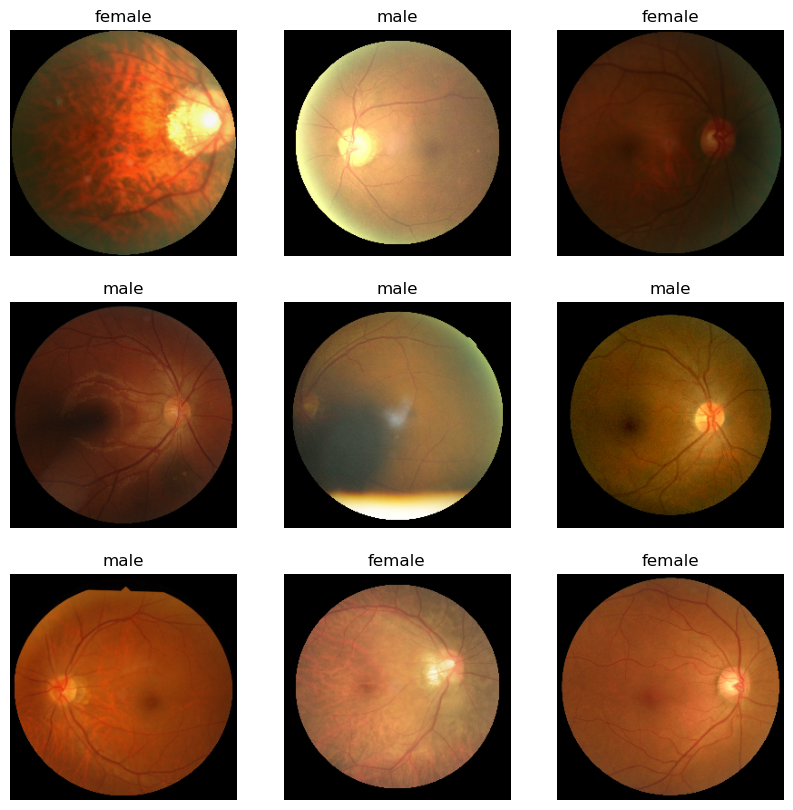

In [10]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Image augmentation with tf.image

In [11]:
train_aug_ds = train_ds.map(augment_sobel)
train_aug_ds = train_aug_ds.map(augment_contrast)
train_aug_gray_ds = train_aug_ds.map(augment_gray) 

testval_aug_ds = testval_ds.map(augment_sobel)
testval_aug_ds = testval_aug_ds.map(augment_contrast) 
testval_aug_gray_ds = testval_aug_ds.map(augment_gray) 

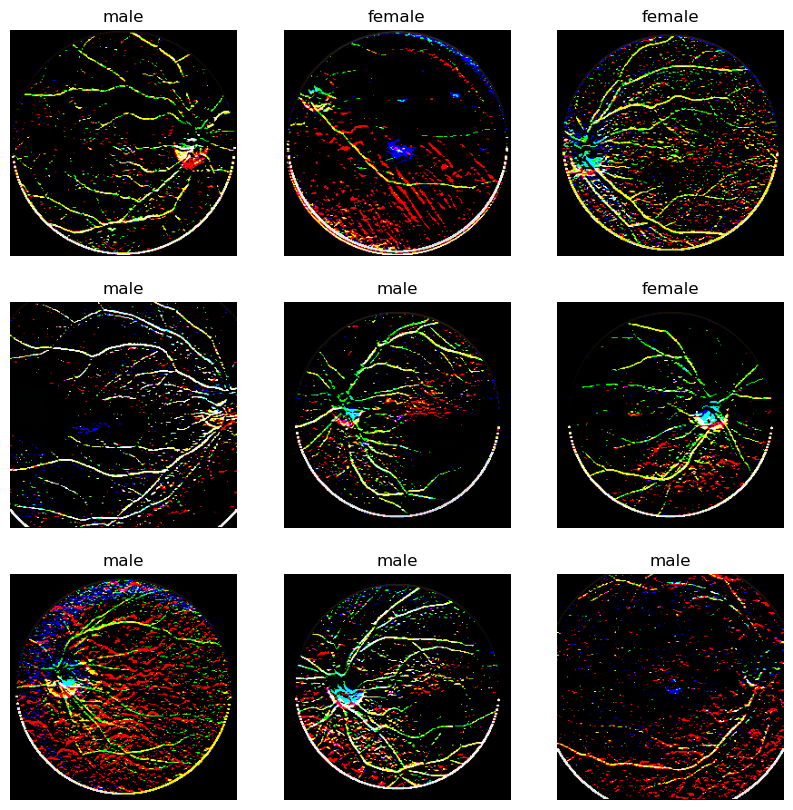

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in train_aug_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # plt.imshow(images[i][:,:,0].numpy().astype("uint8"), cmap='gray')
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

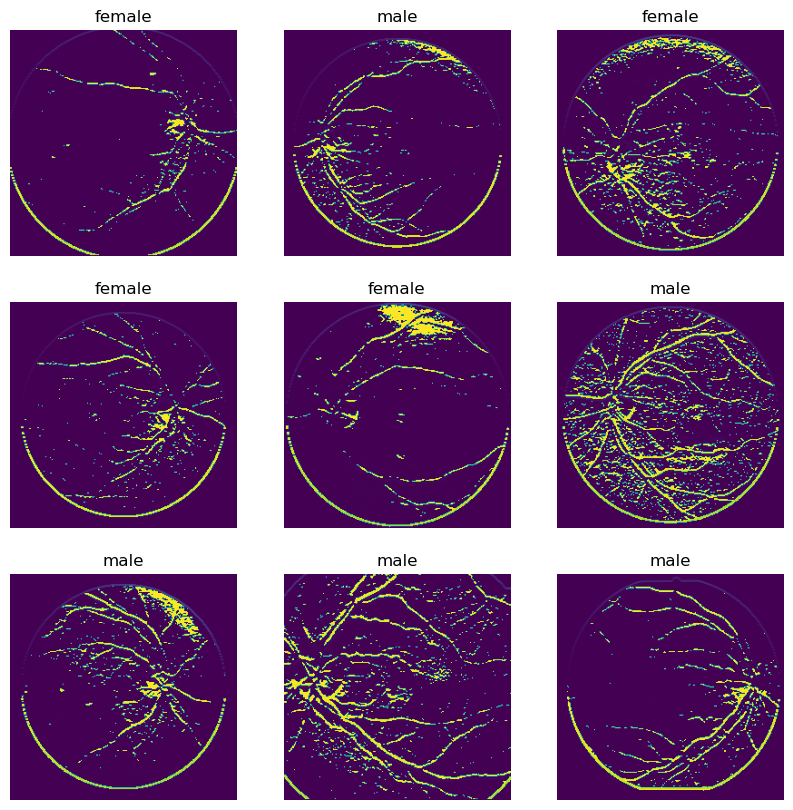

In [13]:
plt.figure(figsize=(10, 10))

for images, labels in train_aug_gray_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][:,:,0].numpy().astype("uint8"))
        # plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
pre_trained_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(250, 250, 3)
)

# freeze convolutional layers and don't include dense layers
pre_trained_model.trainable = False
# pre_trained_model.summary()

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
testval_ds = testval_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_aug_ds = train_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_aug_ds = val_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)
testval_aug_ds = testval_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)


train_aug_gray_ds = train_aug_gray_ds.cache().prefetch(buffer_size=AUTOTUNE)
testval_aug__gray_ds = testval_aug_gray_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1: training from scratch - no augmentation

In [16]:
model = model_scratch_arch1(learning_rate=lr)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 250, 250, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 250, 250, 3)      0         
 tion)                                                           
                                                                 
 conv2d_94 (Conv2D)          (None, 250, 250, 32)      896       
                                                                 
 batch_normalization_94 (Bat  (None, 250, 250, 32)     128       
 chNormalization)                                                
                                                                 
 activation_94 (Activation)  (None, 250, 250, 32)      0

In [18]:
history_list = {}

In [19]:
history = model.fit(
    train_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_ds
)

history_list['model_1'] = history.history

Epoch 1/50


2022-12-19 17:37:58.567330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-19 17:37:59.234880: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-19 17:37:59.235779: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-19 17:37:59.235821: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-19 17:37:59.236773: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-19 17:37:59.236876: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


88/88 [==============================] - 40s 390ms/step - loss: 0.7089 - accuracy: 0.5320 - val_loss: 0.6919 - val_accuracy: 0.5578
Epoch 2/50
88/88 [==============================] - 7s 85ms/step - loss: 0.6935 - accuracy: 0.5394 - val_loss: 0.6906 - val_accuracy: 0.5578
Epoch 3/50
88/88 [==============================] - 7s 85ms/step - loss: 0.6911 - accuracy: 0.5472 - val_loss: 0.6895 - val_accuracy: 0.5578
Epoch 4/50
88/88 [==============================] - 7s 85ms/step - loss: 0.6899 - accuracy: 0.5494 - val_loss: 0.6889 - val_accuracy: 0.5587
Epoch 5/50
88/88 [==============================] - 8s 85ms/step - loss: 0.6896 - accuracy: 0.5483 - val_loss: 0.6882 - val_accuracy: 0.5578
Epoch 6/50
88/88 [==============================] - 7s 85ms/step - loss: 0.6892 - accuracy: 0.5483 - val_loss: 0.6879 - val_accuracy: 0.5578
Epoch 7/50
88/88 [==============================] - 8s 85ms/step - loss: 0.6890 - accuracy: 0.5487 - val_loss: 0.6876 - val_accuracy: 0.5578
Epoch 8/50
88/88 [====

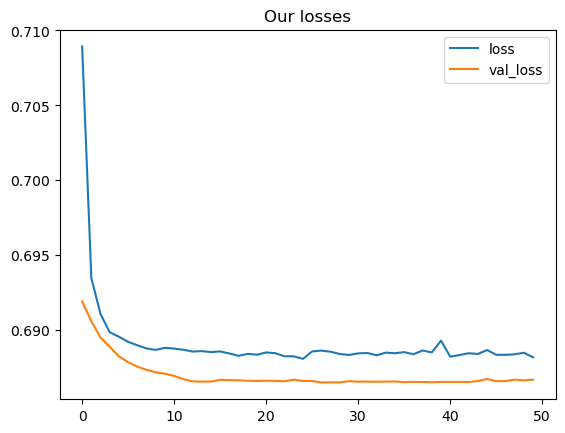

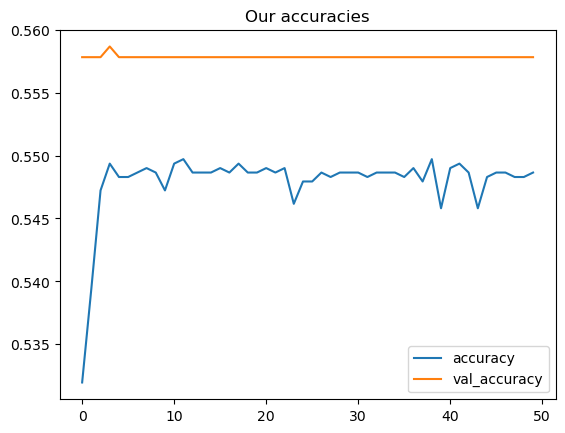

In [20]:
render_history(history.history)

# Model 2: training with inception - no augmentation

In [21]:
model = model_pretrained_arch1(learning_rate=lr)

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 250, 250, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 250, 250, 3)      0         
 tation)                                                         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_96 (Conv2D)          (None, 6, 6, 32)          589856    
                                                                 
 batch_normalization_96 (Bat  (None, 6, 6, 32)         128       
 chNormalization)                                     

In [23]:
history = model.fit(
    train_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_ds
)

history_list['model_2'] = history.history

Epoch 1/50
88/88 [==============================] - 19s 156ms/step - loss: 0.8337 - accuracy: 0.5462 - val_loss: 0.6917 - val_accuracy: 0.5587
Epoch 2/50
88/88 [==============================] - 11s 130ms/step - loss: 0.7061 - accuracy: 0.5458 - val_loss: 0.6925 - val_accuracy: 0.4881
Epoch 3/50
88/88 [==============================] - 11s 129ms/step - loss: 0.6998 - accuracy: 0.5291 - val_loss: 0.6929 - val_accuracy: 0.4864
Epoch 4/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6936 - accuracy: 0.5245 - val_loss: 0.6956 - val_accuracy: 0.4685
Epoch 5/50
88/88 [==============================] - 11s 129ms/step - loss: 0.6888 - accuracy: 0.5494 - val_loss: 0.6942 - val_accuracy: 0.4991
Epoch 6/50
88/88 [==============================] - 11s 129ms/step - loss: 0.6866 - accuracy: 0.5348 - val_loss: 0.6937 - val_accuracy: 0.5111
Epoch 7/50
88/88 [==============================] - 11s 129ms/step - loss: 0.6872 - accuracy: 0.5401 - val_loss: 0.6946 - val_accuracy: 0.4864

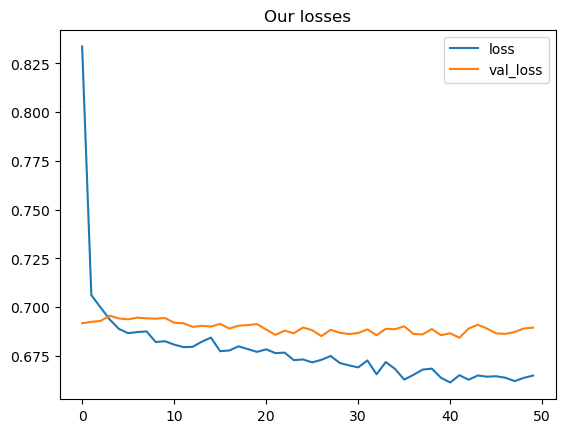

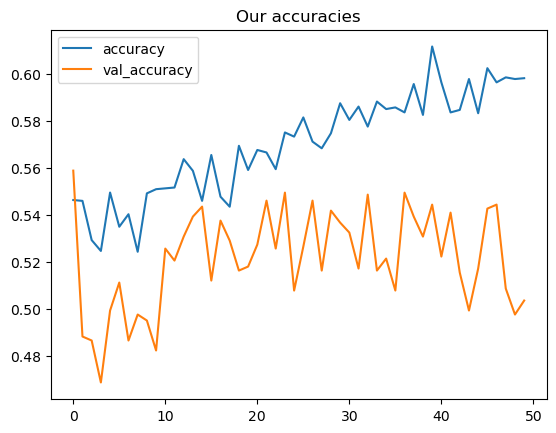

In [24]:
render_history(history.history)

# Model 3: training from scratch - augmentation (gray scale images)

In [25]:
model = model_scratch_arch1(learning_rate=lr, channels=1)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 250, 250, 1)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 250, 250, 1)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 250, 250, 1)      0         
 tation)                                                         
                                                                 
 conv2d_98 (Conv2D)          (None, 250, 250, 32)      320       
                                                                 
 batch_normalization_98 (Bat  (None, 250, 250, 32)     128       
 chNormalization)                                                
                                                                 
 activation_98 (Activation)  (None, 250, 250, 32)     

In [27]:
history = model.fit(
    train_aug_gray_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_aug_gray_ds
)

history_list['model_3'] = history.history

Epoch 1/50
88/88 [==============================] - 40s 422ms/step - loss: 0.7148 - accuracy: 0.5291 - val_loss: 0.6935 - val_accuracy: 0.4422
Epoch 2/50
88/88 [==============================] - 17s 200ms/step - loss: 0.6944 - accuracy: 0.5188 - val_loss: 0.6929 - val_accuracy: 0.5578
Epoch 3/50
88/88 [==============================] - 17s 199ms/step - loss: 0.6914 - accuracy: 0.5497 - val_loss: 0.6917 - val_accuracy: 0.5578
Epoch 4/50
88/88 [==============================] - 18s 202ms/step - loss: 0.6932 - accuracy: 0.5497 - val_loss: 0.6912 - val_accuracy: 0.5578
Epoch 5/50
88/88 [==============================] - 18s 201ms/step - loss: 0.6933 - accuracy: 0.5494 - val_loss: 0.6909 - val_accuracy: 0.5578
Epoch 6/50
88/88 [==============================] - 18s 201ms/step - loss: 0.6879 - accuracy: 0.5472 - val_loss: 0.6901 - val_accuracy: 0.5578
Epoch 7/50
88/88 [==============================] - 17s 200ms/step - loss: 0.6923 - accuracy: 0.5479 - val_loss: 0.6895 - val_accuracy: 0.5578

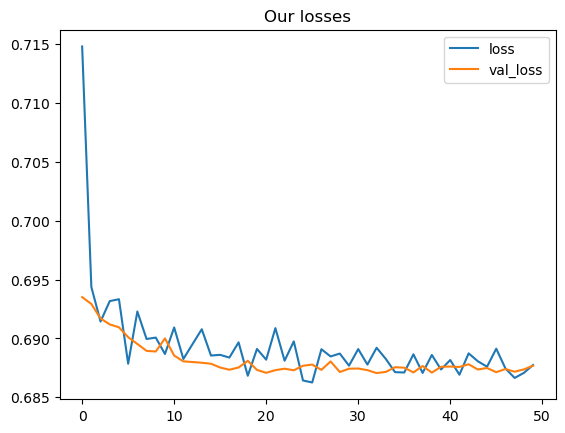

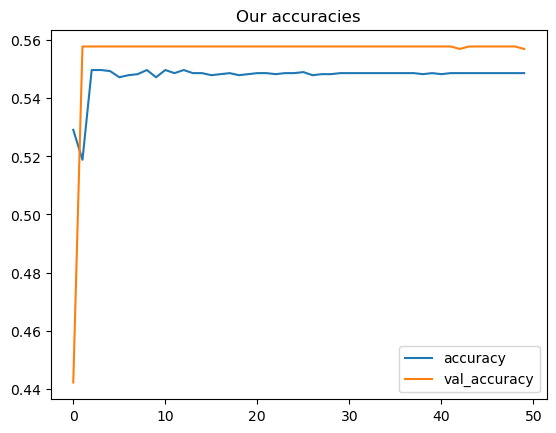

In [28]:
render_history(history.history)

# Model 4: training from the scratch - augmentation

In [29]:
model = model_scratch_arch1(learning_rate=lr)

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 250, 250, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 250, 250, 3)      0         
 tation)                                                         
                                                                 
 conv2d_100 (Conv2D)         (None, 250, 250, 32)      896       
                                                                 
 batch_normalization_100 (Ba  (None, 250, 250, 32)     128       
 tchNormalization)                                               
                                                                 
 activation_100 (Activation)  (None, 250, 250, 32)    

In [31]:
history = model.fit(
    train_aug_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_aug_ds
)

history_list['model_4'] = history.history

Epoch 1/50
88/88 [==============================] - 41s 428ms/step - loss: 0.7404 - accuracy: 0.5405 - val_loss: 0.6923 - val_accuracy: 0.5578
Epoch 2/50
88/88 [==============================] - 8s 87ms/step - loss: 0.6939 - accuracy: 0.5433 - val_loss: 0.6909 - val_accuracy: 0.5578
Epoch 3/50
88/88 [==============================] - 8s 86ms/step - loss: 0.6896 - accuracy: 0.5511 - val_loss: 0.6898 - val_accuracy: 0.5578
Epoch 4/50
88/88 [==============================] - 8s 86ms/step - loss: 0.6921 - accuracy: 0.5487 - val_loss: 0.6891 - val_accuracy: 0.5578
Epoch 5/50
88/88 [==============================] - 8s 86ms/step - loss: 0.6903 - accuracy: 0.5479 - val_loss: 0.6884 - val_accuracy: 0.5578
Epoch 6/50
88/88 [==============================] - 8s 86ms/step - loss: 0.6896 - accuracy: 0.5483 - val_loss: 0.6879 - val_accuracy: 0.5578
Epoch 7/50
88/88 [==============================] - 8s 86ms/step - loss: 0.6889 - accuracy: 0.5479 - val_loss: 0.6876 - val_accuracy: 0.5578
Epoch 8/50


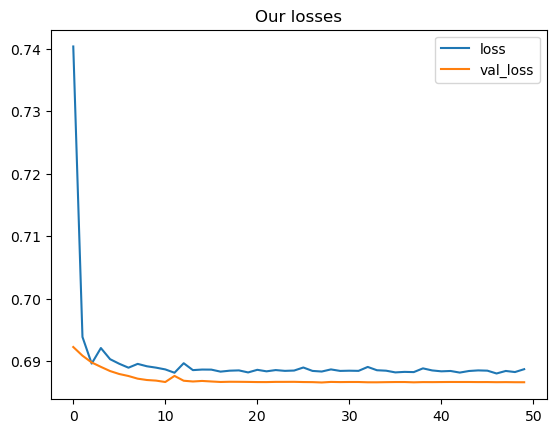

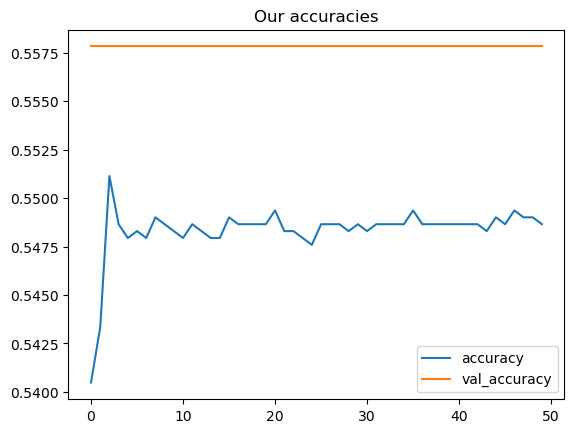

In [32]:
render_history(history.history)

# Model 5 - training with inception - augmentation

In [33]:
model = model_pretrained_arch1(learning_rate=lr)

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 250, 250, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 250, 250, 3)      0         
 tation)                                                         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_102 (Conv2D)         (None, 6, 6, 32)          589856    
                                                                 
 batch_normalization_102 (Ba  (None, 6, 6, 32)         128       
 tchNormalization)                                    

In [35]:
history = model.fit(
    train_aug_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_aug_ds
)

history_list['model_5'] = history.history

Epoch 1/50
88/88 [==============================] - 16s 143ms/step - loss: 0.8452 - accuracy: 0.4656 - val_loss: 0.6942 - val_accuracy: 0.5374
Epoch 2/50
88/88 [==============================] - 11s 129ms/step - loss: 0.7215 - accuracy: 0.4709 - val_loss: 0.6877 - val_accuracy: 0.5493
Epoch 3/50
88/88 [==============================] - 11s 129ms/step - loss: 0.7031 - accuracy: 0.5107 - val_loss: 0.6871 - val_accuracy: 0.5519
Epoch 4/50
88/88 [==============================] - 11s 129ms/step - loss: 0.7053 - accuracy: 0.4879 - val_loss: 0.6868 - val_accuracy: 0.5561
Epoch 5/50
88/88 [==============================] - 11s 129ms/step - loss: 0.6959 - accuracy: 0.5142 - val_loss: 0.6862 - val_accuracy: 0.5578
Epoch 6/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6932 - accuracy: 0.5369 - val_loss: 0.6858 - val_accuracy: 0.5570
Epoch 7/50
88/88 [==============================] - 11s 129ms/step - loss: 0.6918 - accuracy: 0.5369 - val_loss: 0.6857 - val_accuracy: 0.5587

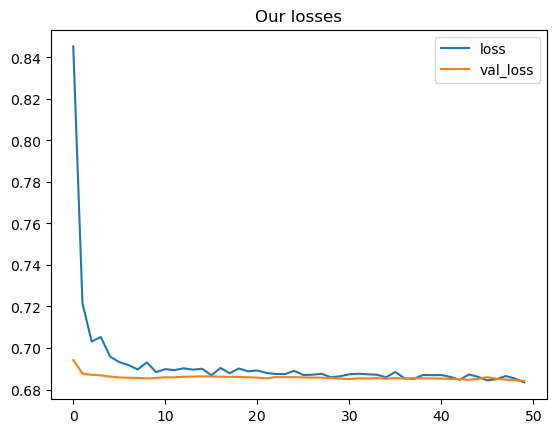

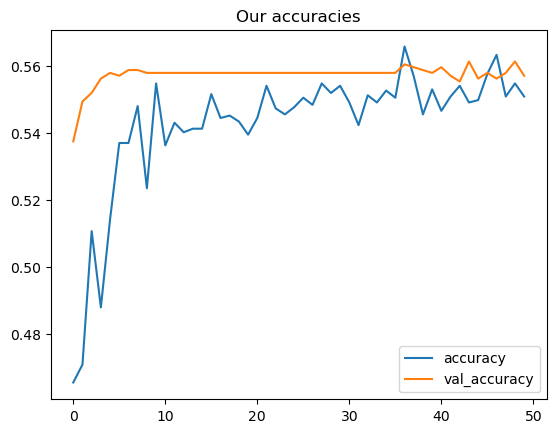

In [36]:
render_history(history.history)

#  Model 6 - training from scratch - no augmentation - another architecture

In [37]:
model = model_scratch_arch2(learning_rate=lr)

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 250, 250, 3)       0         
                                                                 
 random_rotation_5 (RandomRo  (None, 250, 250, 3)      0         
 tation)                                                         
                                                                 
 conv2d_104 (Conv2D)         (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 84, 84, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_105 (Conv2D)         (None, 84, 84, 32)       

In [39]:
history = model.fit(
    train_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_ds
)

history_list['model_6'] = history.history

Epoch 1/50
88/88 [==============================] - 6s 57ms/step - loss: 0.6900 - accuracy: 0.5472 - val_loss: 0.6870 - val_accuracy: 0.5578
Epoch 2/50
88/88 [==============================] - 5s 54ms/step - loss: 0.6886 - accuracy: 0.5487 - val_loss: 0.6862 - val_accuracy: 0.5578
Epoch 3/50
88/88 [==============================] - 5s 54ms/step - loss: 0.6884 - accuracy: 0.5487 - val_loss: 0.6860 - val_accuracy: 0.5578
Epoch 4/50
88/88 [==============================] - 5s 54ms/step - loss: 0.6884 - accuracy: 0.5487 - val_loss: 0.6859 - val_accuracy: 0.5578
Epoch 5/50
88/88 [==============================] - 5s 54ms/step - loss: 0.6883 - accuracy: 0.5487 - val_loss: 0.6859 - val_accuracy: 0.5578
Epoch 6/50
88/88 [==============================] - 5s 54ms/step - loss: 0.6883 - accuracy: 0.5487 - val_loss: 0.6859 - val_accuracy: 0.5578
Epoch 7/50
88/88 [==============================] - 5s 54ms/step - loss: 0.6881 - accuracy: 0.5487 - val_loss: 0.6859 - val_accuracy: 0.5578
Epoch 8/50
88

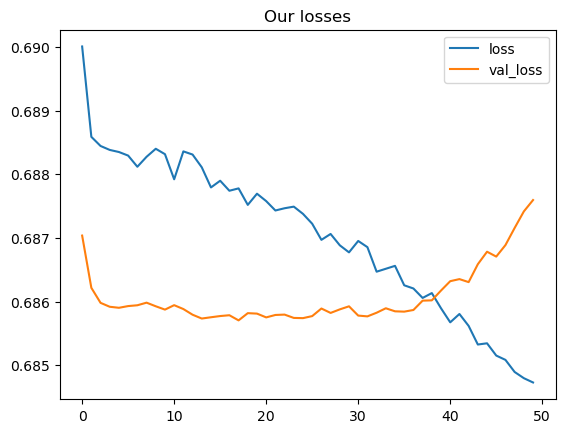

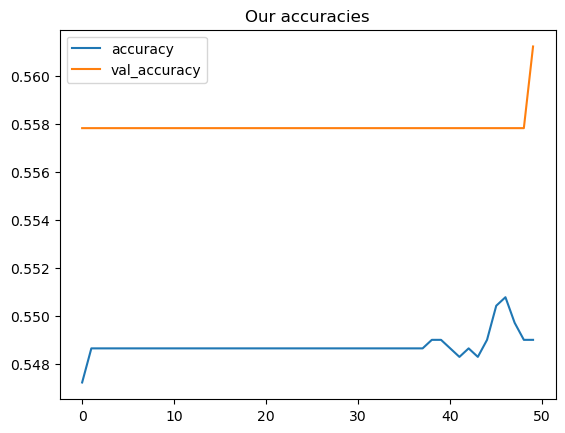

In [55]:
# render_history(history.history)
render_history(history_list['model_6'])

#  Model 7 - training from scratch - augmentation - another architecture

In [40]:
model = model_scratch_arch2(learning_rate=lr)

In [41]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 250, 250, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 250, 250, 3)      0         
 tation)                                                         
                                                                 
 conv2d_109 (Conv2D)         (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 84, 84, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_110 (Conv2D)         (None, 84, 84, 32)       

In [42]:
history = model.fit(
    train_aug_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_aug_ds
)

history_list['model_7'] = history.history

Epoch 1/50
88/88 [==============================] - 6s 56ms/step - loss: 0.6925 - accuracy: 0.5391 - val_loss: 0.6913 - val_accuracy: 0.5578
Epoch 2/50
88/88 [==============================] - 5s 55ms/step - loss: 0.6911 - accuracy: 0.5487 - val_loss: 0.6899 - val_accuracy: 0.5578
Epoch 3/50
88/88 [==============================] - 5s 55ms/step - loss: 0.6902 - accuracy: 0.5487 - val_loss: 0.6889 - val_accuracy: 0.5578
Epoch 4/50
88/88 [==============================] - 5s 55ms/step - loss: 0.6896 - accuracy: 0.5487 - val_loss: 0.6883 - val_accuracy: 0.5578
Epoch 5/50
88/88 [==============================] - 5s 55ms/step - loss: 0.6891 - accuracy: 0.5487 - val_loss: 0.6878 - val_accuracy: 0.5578
Epoch 6/50
88/88 [==============================] - 5s 55ms/step - loss: 0.6889 - accuracy: 0.5487 - val_loss: 0.6874 - val_accuracy: 0.5578
Epoch 7/50
88/88 [==============================] - 5s 55ms/step - loss: 0.6887 - accuracy: 0.5487 - val_loss: 0.6872 - val_accuracy: 0.5578
Epoch 8/50
88

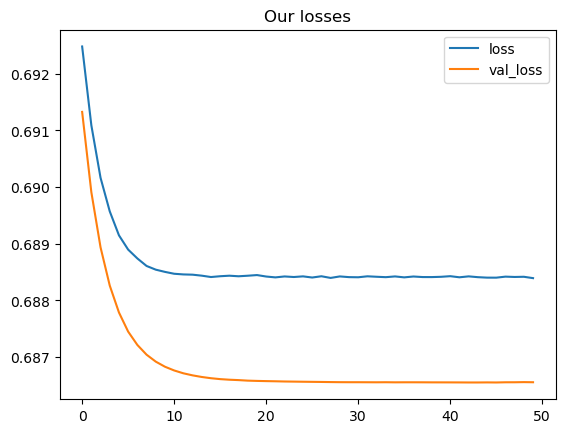

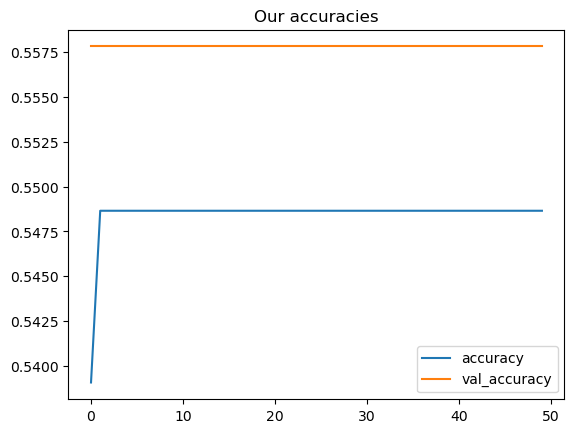

In [56]:
# render_history(history.history)
render_history(history_list['model_7'])

# Model 8 - training with inception - no augmentation - another architecture

In [43]:
model = model_pretrained_arch2(learning_rate=lr)

In [44]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 250, 250, 3)       0         
                                                                 
 random_rotation_7 (RandomRo  (None, 250, 250, 3)      0         
 tation)                                                         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_114 (Conv2D)         (None, 6, 6, 16)          294928    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 2, 2, 16)         0         
 g2D)                                                 

In [45]:
history = model.fit(
    train_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_ds
)

history_list['model_5'] = history.history

Epoch 1/50
88/88 [==============================] - 17s 150ms/step - loss: 0.6922 - accuracy: 0.5391 - val_loss: 0.6906 - val_accuracy: 0.5578
Epoch 2/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6904 - accuracy: 0.5487 - val_loss: 0.6889 - val_accuracy: 0.5578
Epoch 3/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6895 - accuracy: 0.5487 - val_loss: 0.6879 - val_accuracy: 0.5578
Epoch 4/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6890 - accuracy: 0.5487 - val_loss: 0.6874 - val_accuracy: 0.5578
Epoch 5/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6887 - accuracy: 0.5487 - val_loss: 0.6870 - val_accuracy: 0.5578
Epoch 6/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6886 - accuracy: 0.5487 - val_loss: 0.6868 - val_accuracy: 0.5578
Epoch 7/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6885 - accuracy: 0.5487 - val_loss: 0.6867 - val_accuracy: 0.5578

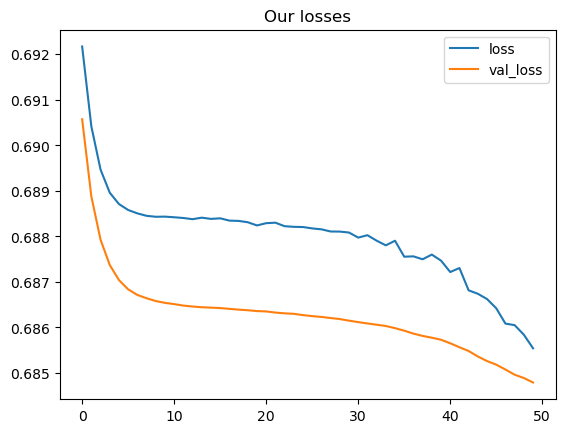

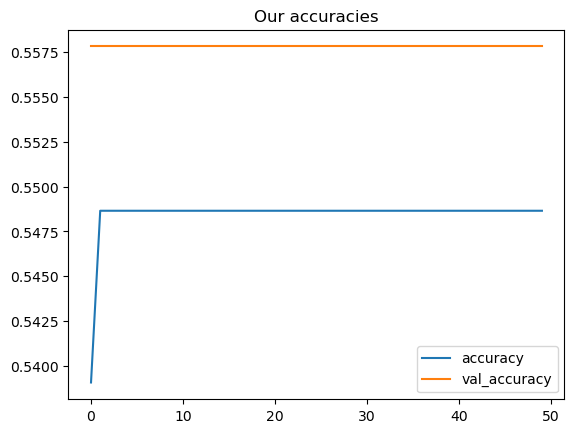

In [46]:
render_history(history.history)

#  Model 9 - training with inception - augmentation - another architecture

In [47]:
model = model_pretrained_arch2(learning_rate=lr)

In [48]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 250, 250, 3)       0         
                                                                 
 random_rotation_8 (RandomRo  (None, 250, 250, 3)      0         
 tation)                                                         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_119 (Conv2D)         (None, 6, 6, 16)          294928    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 2, 2, 16)         0         
 g2D)                                                 

In [49]:
history = model.fit(
    train_aug_ds,
    batch_size=20,
    epochs=epochs,
    validation_data=testval_aug_ds
)

history_list['model_5'] = history.history

Epoch 1/50
88/88 [==============================] - 17s 145ms/step - loss: 0.6918 - accuracy: 0.5476 - val_loss: 0.6901 - val_accuracy: 0.5578
Epoch 2/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6900 - accuracy: 0.5487 - val_loss: 0.6884 - val_accuracy: 0.5578
Epoch 3/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6891 - accuracy: 0.5487 - val_loss: 0.6875 - val_accuracy: 0.5578
Epoch 4/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6888 - accuracy: 0.5487 - val_loss: 0.6871 - val_accuracy: 0.5578
Epoch 5/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6886 - accuracy: 0.5487 - val_loss: 0.6869 - val_accuracy: 0.5578
Epoch 6/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6885 - accuracy: 0.5487 - val_loss: 0.6867 - val_accuracy: 0.5578
Epoch 7/50
88/88 [==============================] - 11s 130ms/step - loss: 0.6885 - accuracy: 0.5487 - val_loss: 0.6866 - val_accuracy: 0.5578

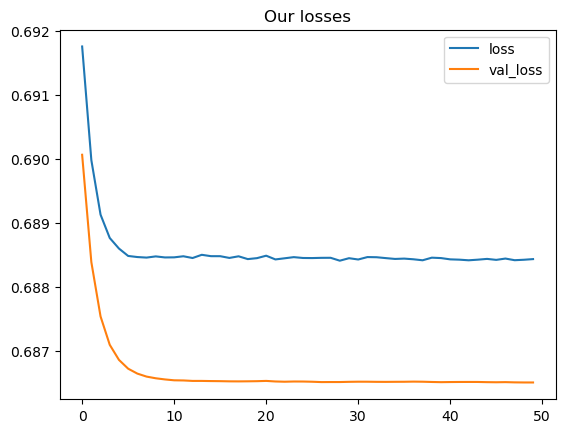

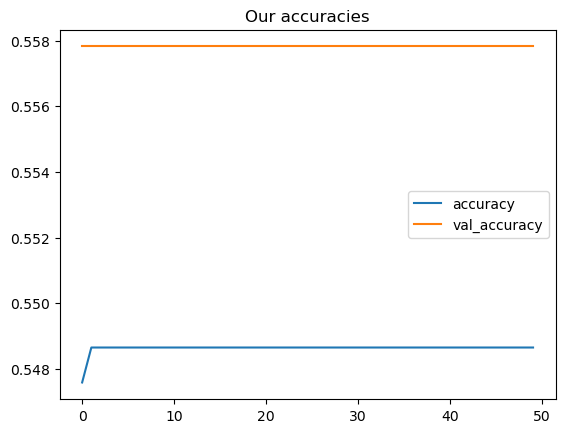

In [50]:
render_history(history.history)

# Learning rate

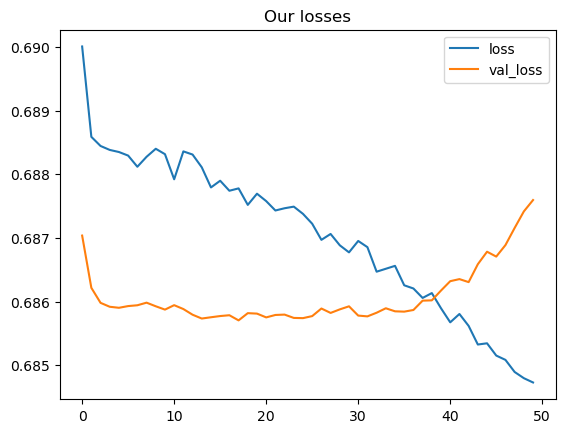

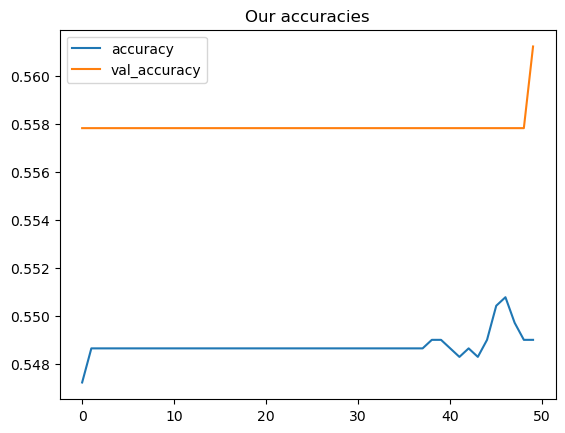

In [54]:
render_history(history_list['model_6'])

In [53]:
history_list['model_6']

{'loss': [0.6900075674057007,
  0.6885877847671509,
  0.6884442567825317,
  0.6883820295333862,
  0.6883491277694702,
  0.6882930397987366,
  0.6881177425384521,
  0.6882741451263428,
  0.6884003281593323,
  0.688315212726593,
  0.6879208087921143,
  0.6883591413497925,
  0.6883095502853394,
  0.6881089806556702,
  0.6877927184104919,
  0.6878980398178101,
  0.687740683555603,
  0.6877778768539429,
  0.6875185370445251,
  0.6876941919326782,
  0.6875777840614319,
  0.6874303817749023,
  0.6874657273292542,
  0.6874909996986389,
  0.6873772144317627,
  0.6872223019599915,
  0.6869690418243408,
  0.6870617270469666,
  0.6868834495544434,
  0.6867725253105164,
  0.6869516372680664,
  0.6868544220924377,
  0.6864689588546753,
  0.686514675617218,
  0.6865604519844055,
  0.686255156993866,
  0.6862047910690308,
  0.6860564351081848,
  0.6861326694488525,
  0.685893714427948,
  0.685673177242279,
  0.6858041882514954,
  0.6856169104576111,
  0.6853244304656982,
  0.6853436231613159,
  0.6851

In [58]:
scores = {}

for lr in [0.00001, 0.00003, 0.00007, 0.0001, 0.001, 0.01, 0.1]:
    print(f'learning rate = {lr}')
    
    model = model_scratch_arch1(learning_rate=lr)
    
    history = model.fit(train_ds, epochs=10, validation_data=testval_ds)
    scores[lr] = history.history
    
    print()
    print()

learning rate = 1e-05
Epoch 1/10
88/88 [==============================] - 9s 87ms/step - loss: 0.7176 - accuracy: 0.5011 - val_loss: 0.6910 - val_accuracy: 0.5612
Epoch 2/10
88/88 [==============================] - 7s 85ms/step - loss: 0.6999 - accuracy: 0.5188 - val_loss: 0.6907 - val_accuracy: 0.5315
Epoch 3/10
88/88 [==============================] - 8s 86ms/step - loss: 0.7012 - accuracy: 0.5174 - val_loss: 0.6910 - val_accuracy: 0.5238
Epoch 4/10
88/88 [==============================] - 7s 85ms/step - loss: 0.6991 - accuracy: 0.5007 - val_loss: 0.6920 - val_accuracy: 0.5332
Epoch 5/10
88/88 [==============================] - 8s 85ms/step - loss: 0.6953 - accuracy: 0.5256 - val_loss: 0.6934 - val_accuracy: 0.5102
Epoch 6/10
88/88 [==============================] - 8s 86ms/step - loss: 0.6948 - accuracy: 0.5085 - val_loss: 0.6929 - val_accuracy: 0.5298
Epoch 7/10
88/88 [==============================] - 8s 85ms/step - loss: 0.6950 - accuracy: 0.5142 - val_loss: 0.6934 - val_accuracy

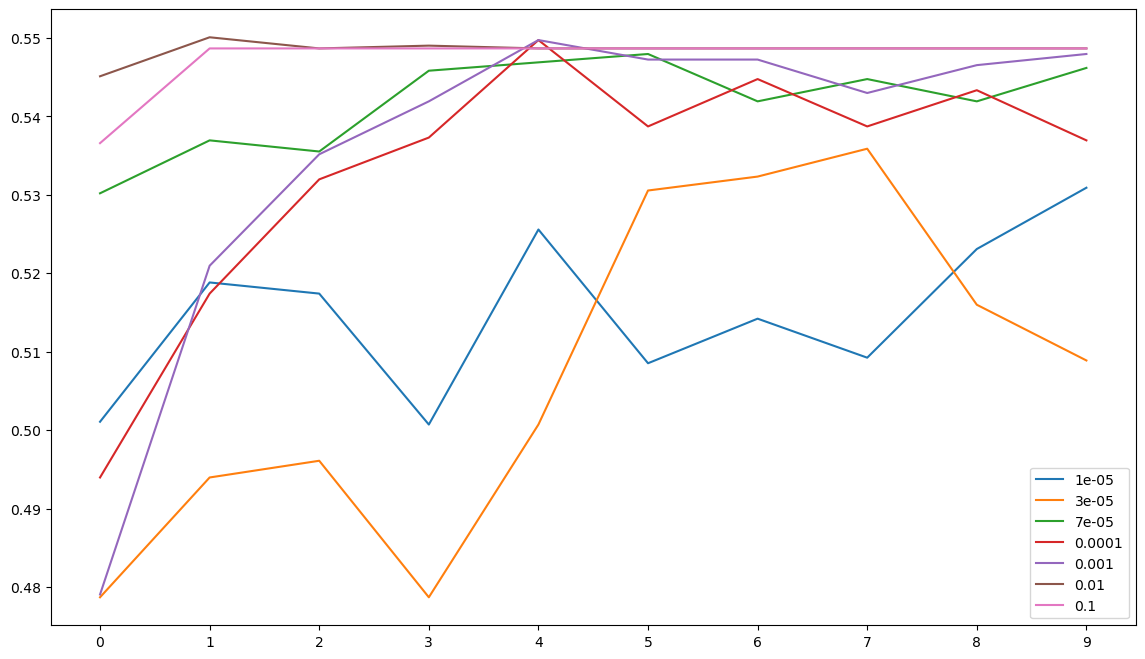

In [59]:
# sgd
plt.figure(figsize=(14, 8))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
        
plt.xticks(np.arange(10))
plt.legend()
plt.show()

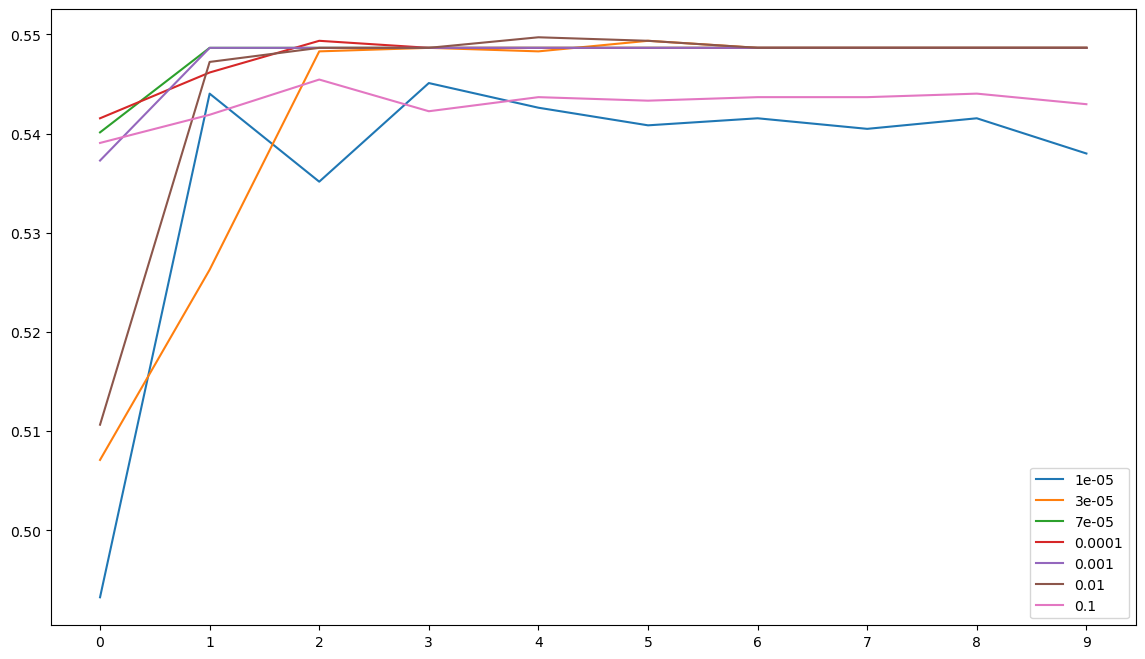

In [56]:
# rmsprop
plt.figure(figsize=(14, 8))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
        
plt.xticks(np.arange(10))
plt.legend()
plt.show()

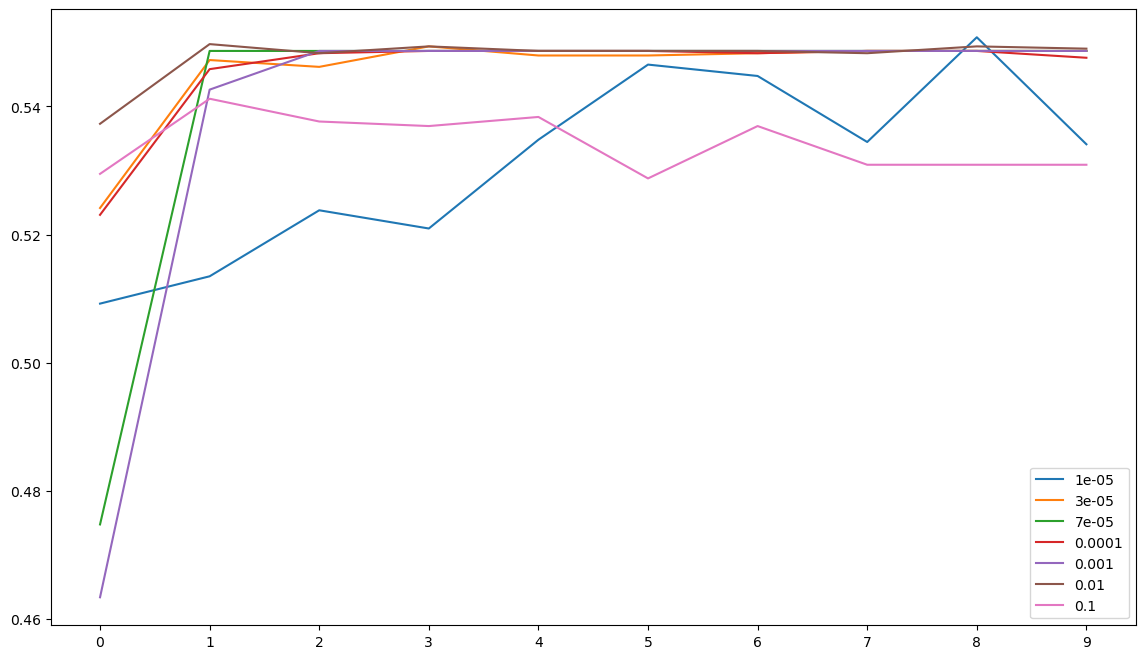

In [48]:
# adam
plt.figure(figsize=(14, 8))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
        
plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [49]:
scores = {}

for lr in [0.00001, 0.00003, 0.00007, 0.0001, 0.001, 0.01, 0.1]:
    print(f'learning rate = {lr}')
       
    model = model_pretrained_arch1(learning_rate=lr)
    
    history = model.fit(train_ds, epochs=10, validation_data=testval_ds)
    scores[lr] = history.history
    
    print()
    print()

learning rate = 1e-05
Epoch 1/10
88/88 [==============================] - 20s 159ms/step - loss: 0.7982 - accuracy: 0.5007 - val_loss: 0.6959 - val_accuracy: 0.5272
Epoch 2/10
88/88 [==============================] - 12s 131ms/step - loss: 0.7654 - accuracy: 0.4876 - val_loss: 0.6861 - val_accuracy: 0.5502
Epoch 3/10
88/88 [==============================] - 12s 131ms/step - loss: 0.7497 - accuracy: 0.4801 - val_loss: 0.6858 - val_accuracy: 0.5519
Epoch 4/10
88/88 [==============================] - 12s 131ms/step - loss: 0.7322 - accuracy: 0.5117 - val_loss: 0.6872 - val_accuracy: 0.5502
Epoch 5/10
88/88 [==============================] - 12s 132ms/step - loss: 0.7229 - accuracy: 0.5146 - val_loss: 0.6868 - val_accuracy: 0.5434
Epoch 6/10
88/88 [==============================] - 12s 132ms/step - loss: 0.7318 - accuracy: 0.5078 - val_loss: 0.6880 - val_accuracy: 0.5332
Epoch 7/10
88/88 [==============================] - 12s 131ms/step - loss: 0.7188 - accuracy: 0.5032 - val_loss: 0.6878 

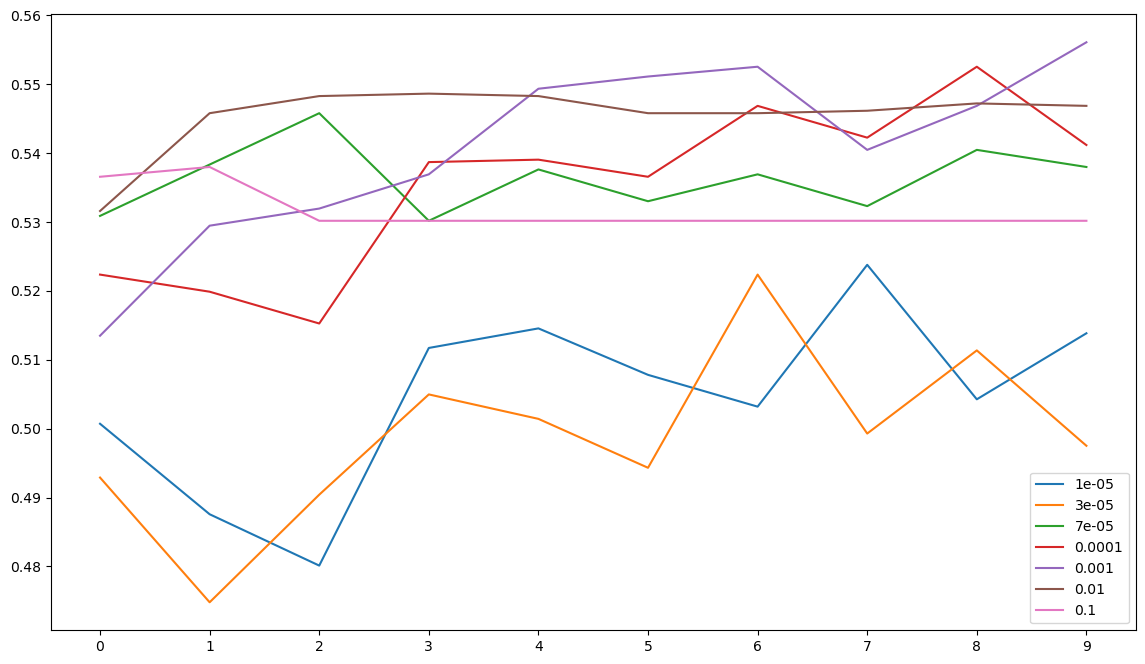

In [50]:
plt.figure(figsize=(14, 8))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
        
plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [51]:
scores = {}

for lr in [0.00001, 0.00003, 0.00007, 0.0001, 0.001, 0.01, 0.1]:
    print(f'learning rate = {lr}')
    
    
    model = model_scratch_arch2(learning_rate=lr)
    
    history = model.fit(train_ds, epochs=10, validation_data=testval_ds)
    scores[lr] = history.history
    
    print()
    print()

learning rate = 1e-05
Epoch 1/10
88/88 [==============================] - 7s 59ms/step - loss: 0.6922 - accuracy: 0.5234 - val_loss: 0.6899 - val_accuracy: 0.5578
Epoch 2/10
88/88 [==============================] - 5s 56ms/step - loss: 0.6892 - accuracy: 0.5487 - val_loss: 0.6868 - val_accuracy: 0.5578
Epoch 3/10
88/88 [==============================] - 5s 56ms/step - loss: 0.6882 - accuracy: 0.5487 - val_loss: 0.6856 - val_accuracy: 0.5578
Epoch 4/10
88/88 [==============================] - 5s 55ms/step - loss: 0.6879 - accuracy: 0.5487 - val_loss: 0.6854 - val_accuracy: 0.5578
Epoch 5/10
88/88 [==============================] - 5s 55ms/step - loss: 0.6878 - accuracy: 0.5487 - val_loss: 0.6853 - val_accuracy: 0.5578
Epoch 6/10
88/88 [==============================] - 5s 56ms/step - loss: 0.6879 - accuracy: 0.5487 - val_loss: 0.6854 - val_accuracy: 0.5578
Epoch 7/10
88/88 [==============================] - 5s 55ms/step - loss: 0.6875 - accuracy: 0.5487 - val_loss: 0.6853 - val_accuracy

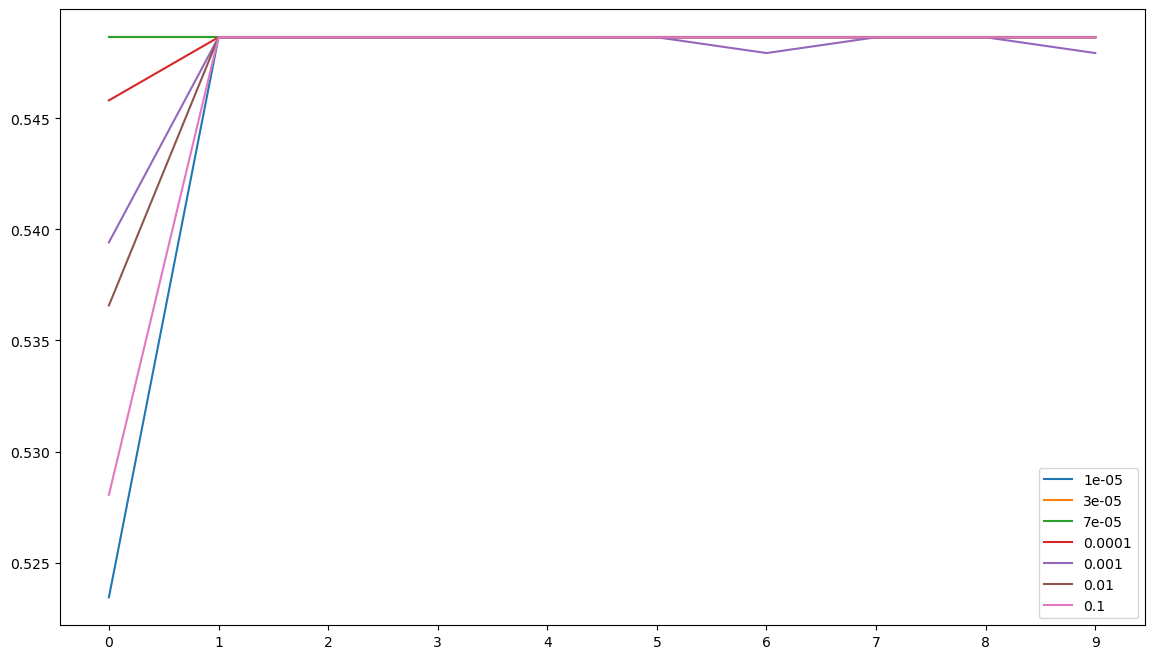

In [52]:
plt.figure(figsize=(14, 8))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
        
plt.xticks(np.arange(10))
plt.legend()
plt.show()

In [53]:
scores = {}

for lr in [0.00001, 0.00003, 0.00007, 0.0001, 0.001, 0.01, 0.1]:
    print(f'learning rate = {lr}')
    
    
    model = model_pretrained_arch2(learning_rate=lr)
    
    history = model.fit(train_ds, epochs=10, validation_data=testval_ds)
    scores[lr] = history.history
    
    print()
    print()

learning rate = 1e-05
Epoch 1/10
88/88 [==============================] - 17s 144ms/step - loss: 0.6928 - accuracy: 0.5497 - val_loss: 0.6920 - val_accuracy: 0.5578
Epoch 2/10
88/88 [==============================] - 11s 130ms/step - loss: 0.6910 - accuracy: 0.5487 - val_loss: 0.6884 - val_accuracy: 0.5578
Epoch 3/10
88/88 [==============================] - 11s 129ms/step - loss: 0.6886 - accuracy: 0.5487 - val_loss: 0.6863 - val_accuracy: 0.5578
Epoch 4/10
88/88 [==============================] - 11s 129ms/step - loss: 0.6877 - accuracy: 0.5487 - val_loss: 0.6856 - val_accuracy: 0.5578
Epoch 5/10
88/88 [==============================] - 11s 129ms/step - loss: 0.6873 - accuracy: 0.5487 - val_loss: 0.6853 - val_accuracy: 0.5578
Epoch 6/10
88/88 [==============================] - 11s 129ms/step - loss: 0.6862 - accuracy: 0.5487 - val_loss: 0.6851 - val_accuracy: 0.5578
Epoch 7/10
88/88 [==============================] - 11s 130ms/step - loss: 0.6860 - accuracy: 0.5487 - val_loss: 0.6848 

KeyboardInterrupt: 

--------------------------------

In [ ]:
plt.figure(figsize=(14, 8))
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
        
plt.xticks(np.arange(10))
plt.legend()
plt.show()